Use previous lab notebooks to install and run a spark instance, and then follow the instructions within "TO DO" comments

In [ ]:
# TO DO: set-up spark

In [ ]:
# TO DO:  install findspark 

In [ ]:
# TO DO: init spark (ensure SPARK_HOME set to same version as we download)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/opt/apache-spark"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *


# use 'spark' as reference (as per standard approach)
spark = SparkSession.builder.appName("bikes").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/24 16:16:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# get bike hire file for given year from TfL open data



In [ ]:
# TO DO: read a file into a DF called "j_df"
file="./1. Journey*csv"
j_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(file))

In [ ]:
# see how many entries (rows) in data
numRows = j_df.count()
print("there are ",numRows," rows")


there are  463523  rows


we use '_pdf' to denote 'pandas data frame'


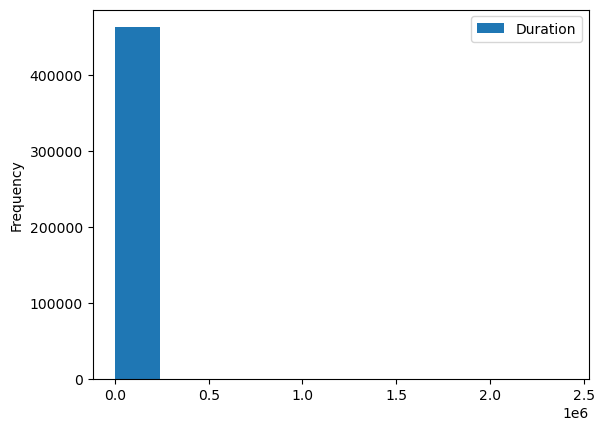

In [ ]:
# how to do a histogram of e.g. duration
# there is no graphical element of Spark (CHECK) so need to do locally
# we can use Python libs pandas & matplotlib

# import Python libs
import matplotlib.pyplot as plt
import pandas as pd

plot_pdf = j_df[["Duration"]].toPandas() # take just "Duration" col, convert to pandas dataframe structure ready to plot
#print("we have ", plot_df.count()," elements to plot")
print("we use '_pdf' to denote 'pandas data frame'")

plot_pdf.plot(kind="hist")
plt.show()

The above graph is not very information so we need to wrangle our data...

In [ ]:
# recall...
j_df.agg({"Duration": "min"}).show()
j_df.agg({"Duration": "mean"}).show()
j_df.agg({"Duration": "max"}).show()
j_df.agg({"Duration": "skewness"}).show()

+-------------+
|min(Duration)|
+-------------+
|            0|
+-------------+

+------------------+
|     avg(Duration)|
+------------------+
|1232.3542521083095|
+------------------+

+-------------+
|max(Duration)|
+-------------+
|      2406000|
+-------------+

+------------------+
|skewness(Duration)|
+------------------+
| 76.22383648516934|
+------------------+



sample has  430  elements


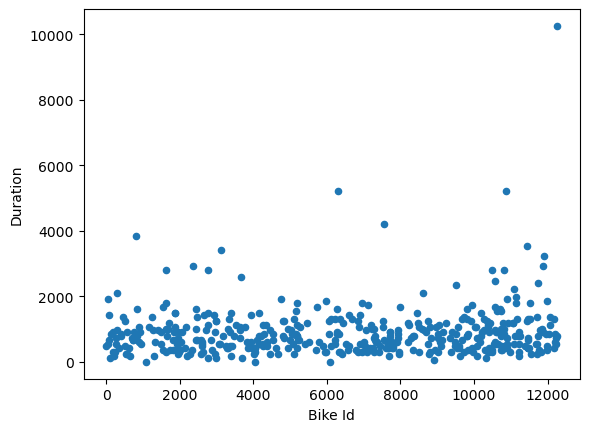

In [ ]:
# look at values (random sampling)
sample_df=j_df.sample(0.001) # 0.001 of 0.5M is 500
print("sample has ",sample_df.count()," elements")
plotSample_pdf = sample_df[["Bike Id", "Duration"]].toPandas()
plotSample_pdf.plot(kind="scatter", y="Duration", x="Bike Id") # scatter plot (duration .v. bikeID)
plt.show()

In [ ]:
# so vast majority of rides in this month have "Duration" under 2 hours
total = j_df.count()
numExceed = j_df.filter("Duration > 7200").count()
print("Of all rides, percentage over 2 hours:", (numExceed*100)/total)



Of all rides, percentage over 2 hours: 0.6034220524116387


In [ ]:
# DO DO: add a histogram of ride Duration less or equal to 2 hours

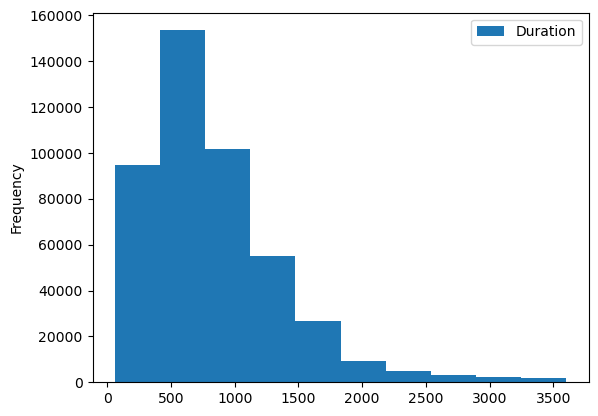

In [ ]:
# can refine further
# e.g. remove rides with Duration of 0 seconds or over 3600
rides_df = j_df.filter("Duration > 0").filter("Duration <= 3600")[["Duration"]]
# now convert to Pandas df and plot
rides_df.toPandas().plot(kind="hist")
plt.show()

In [ ]:
# ignore the top outliers
n = 50
threshold = j_df.orderBy("Duration", ascending=False).head(n)[n-1].Duration 
print("Ignoring over ", threshold, " seconds and less than 1 minute")

Ignoring over  600420  seconds and less than 1 minute


histogram with 100 bins and log of frequency for rides lasting more than 5 minutes


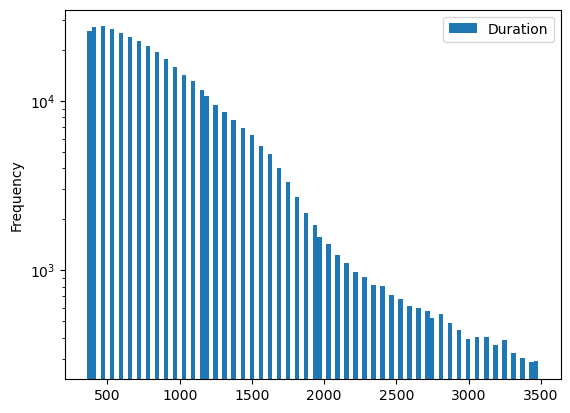

In [ ]:
# TO DO: manually use threshold for given month 
print("histogram with 100 bins and log of frequency for rides lasting more than 5 minutes")
j_df.filter("Duration > 300").filter("Duration < 3500")[["Duration"]].toPandas().plot(kind="hist", bins=100, log=True)
plt.show()

Comparing plots...

comparing >=5 min but less than or equal to 2 hours by ploting PDF


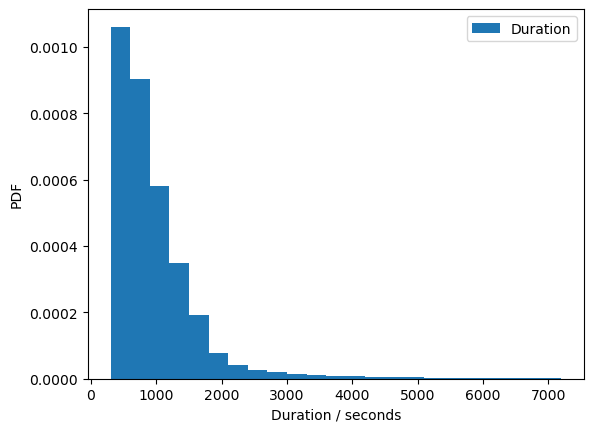

for end aug dataset we have  902300  rows of data


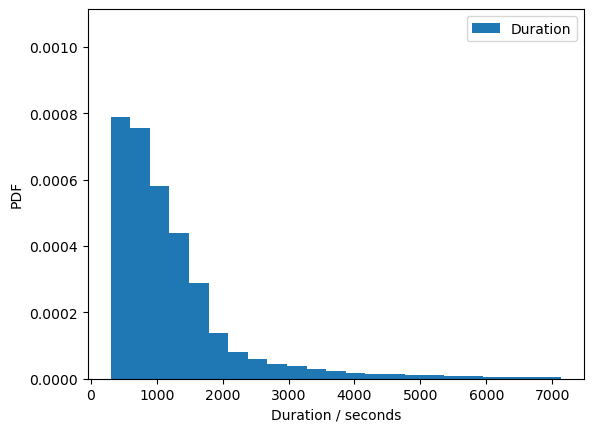

i.e. some shift towards longer rides?


In [ ]:
# compare plots for jan and part of aug (file 9a)
print("comparing >=5 min but less than or equal to 2 hours by ploting PDF")
rides_df = j_df.filter("Duration >= 300").filter("Duration <= 7200")[["Duration"]]
# now convert to Pandas df and plot
rides_df.toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
#plt.ylim((10.0,100000.0))
# get y range (so can use in next plot)
minY,maxY = plt.ylim()
plt.show()

aug_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load('./9a*csv'))
print("for end aug dataset we have ", aug_df.count(), " rows of data")
aug_df.filter("Duration >= 300").filter("Duration < 7200")[["Duration"]].toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
plt.ylim(minY, maxY) # ensure same scales for x- and y- axes
plt.show()
print("i.e. some shift towards longer rides?")


ALL of aug has  1486918  entries


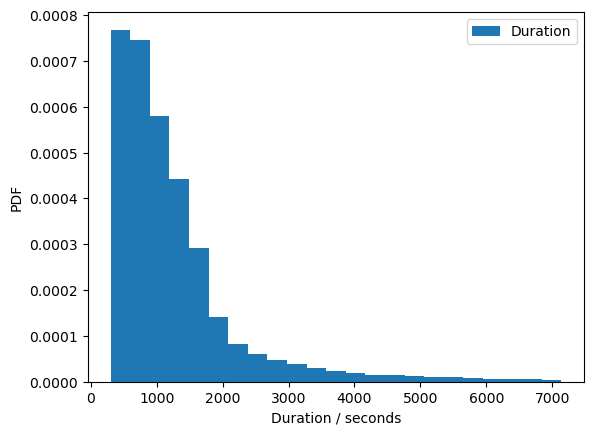

In [ ]:
# aug is covered in TWO files
# 8b (01Aug to 16Aug)
# 9a (17Aug to 31Aug)

# let's read in both and plot
aug_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(['./8b*csv', './9a*csv']))

print("ALL of aug has ", aug_df.count(), " entries")
# attempt to plot
aug_df.filter("Duration >= 300").filter("Duration < 7200")[["Duration"]].toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
#plt.ylim(minY, maxY)
plt.show()

In [ ]:
# what about June (TWO files sort of)
june_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(['./6*csv',   # 25May to 21Jun
                './7*csv'])) # 22Jun to 19Jul
print("we have ", aug_df.count(), " entries")
# attempt to plot
june_df.filter("Duration >= 300").filter("Duration < 7200")[["Duration"]].toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
#plt.ylim(minY, maxY)
plt.show()

we have  1486918  entries


TypeError: no numeric data to plot


let us look at UNION: read in each file then append 2nd DF to 1st DF



In [18]:
# using 8b file and sampling
temp_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('./8b*csv')

# TO DO: how many rows in temp_df?

# sample (ratio to obtain) - NB this is not exact ratio
# let's take two samples and use UNION

sampA_df = temp_df.sample(0.00002)
print("sample A: ", sampA_df.count())
sampA_df.show(sampA_df.count())

sampB_df = temp_df.sample(0.00001)
print("sample B: ", sampB_df.count())
sampB_df.show(sampB_df.count())


sample A:  17


+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 35910679|     780|    976|04/08/2014 18:04|          201|Dorset Square, Ma...|04/08/2014 17:51|             15|Great Russell Str...|
| 36324796|    1200|  12413|15/08/2014 17:22|          199|Great Tower Stree...|15/08/2014 17:02|            239|Warren Street Sta...|
| 36097314|     300|  12514|09/08/2014 11:25|           13|Scala Street, Fit...|09/08/2014 11:20|            383|  Frith Street, Soho|
| 36239913|     660|    488|13/08/2014 08:10|          166|Seville Street, K...|13/08/2014 07:59|            584|Ilchester Gardens...|
| 36016834|     720|  12591|07/08/2014 09:00|          

In [19]:
# now combine in to one dataframe (same schema (contrast 'join') but keeping all rows of data)
# this is a UNION
mix_df = sampA_df.union(sampB_df)
print("mix: ",mix_df.count())
mix_df.show(mix_df.count())

mix:  23


+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 35910679|     780|    976|04/08/2014 18:04|          201|Dorset Square, Ma...|04/08/2014 17:51|             15|Great Russell Str...|
| 36324796|    1200|  12413|15/08/2014 17:22|          199|Great Tower Stree...|15/08/2014 17:02|            239|Warren Street Sta...|
| 36097314|     300|  12514|09/08/2014 11:25|           13|Scala Street, Fit...|09/08/2014 11:20|            383|  Frith Street, Soho|
| 36239913|     660|    488|13/08/2014 08:10|          166|Seville Street, K...|13/08/2014 07:59|            584|Ilchester Gardens...|
| 36016834|     720|  12591|07/08/2014 09:00|          

Example of some data wrangling

NB we expect an "analysis exception" when running the next cell

In [20]:
# what about june?
# let's try reading datasets 6 and 7 then form their union
juneA_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load('./6*csv'))  # 25May to 21Jun
juneB_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load('./7*csv'))  # 22Jun to 19Jul

mix_df = juneA_df.union(juneB_df)
print("mix: ",mix_df.count())
mix_df.show(mix_df.count())

AnalysisException: Union can only be performed on tables with the same number of columns, but the first table has 12 columns and the second table has 9 columns;
'Union false, false
:- Relation [Rental Id#750,Duration#751,Bike Id#752,End Date#753,EndStation Id#754,EndStation Name#755,Start Date#756,StartStation Id#757,StartStation Name#758,_c9#759,_c10#760,_c11#761] csv
+- Relation [Rental Id#791,Duration#792,Bike Id#793,End Date#794,EndStation Id#795,EndStation Name#796,Start Date#797,StartStation Id#798,StartStation Name#799] csv


In [21]:
# read the "Analysis Exception" carefully
# perhaps a clue?

# TO DO: print out schema + 2 rows for each juneA/B DF

# print scheme directly
juneA_df.printSchema()
juneB_df.printSchema()

root
 |-- Rental Id: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)

root
 |-- Rental Id: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [22]:
# so for some reason the '6' file (juneA dataframe) scheme is "incorrect"
# ... what can we do?

# first see if anything in these extra cols that we may need
juneA_df[["_c9", "_c10", "_c11"]].distinct().show()

23/05/24 16:19:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , , 
 Schema: _c9, _c10, _c11
Expected: _c9 but found: 
CSV file: file:///home/seirra/Documents/src/mmu-big-data/6.%20Journey%20Data%20Extract%2025May14-21Jun14.csv
+----+----+----+
| _c9|_c10|_c11|
+----+----+----+
|null|null|null|
+----+----+----+



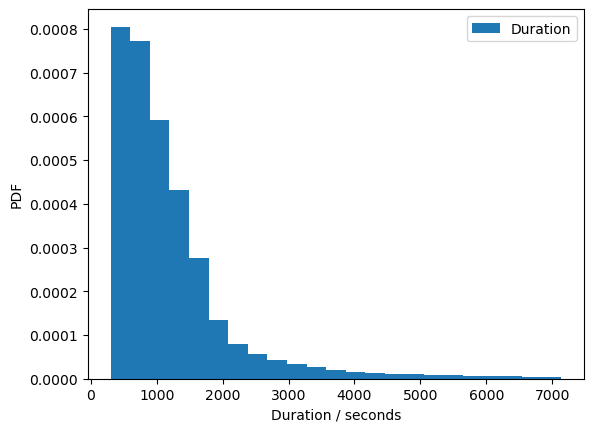

In [23]:
# so no actual info, thus we can amend our data set by ignoring these columns and using only "Duration" 
meld_df = juneA_df[["Duration"]].union(juneB_df[["Duration"]]) # i.e. a union of only the 'Duration' columns

# now filter the union, convert to Pandas and plot PDF
meld_df.filter("Duration >= 300").filter("Duration < 7200").toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
#plt.ylim(minY, maxY)
plt.show()

Filter by timestamp (& using 'alias' for convenience)

quick check we do not see any MAY dates
+-------------------+--------+
|              start|Duration|
+-------------------+--------+
|2014-06-03 13:05:00|    1440|
|2014-06-09 18:15:00|     960|
|2014-06-11 19:37:00|    1260|
|2014-06-15 13:59:00|     300|
|2014-06-19 00:41:00|    1140|
+-------------------+--------+
only showing top 5 rows

plot PDF of cleansed data for June only, rides>=5m and <2hr


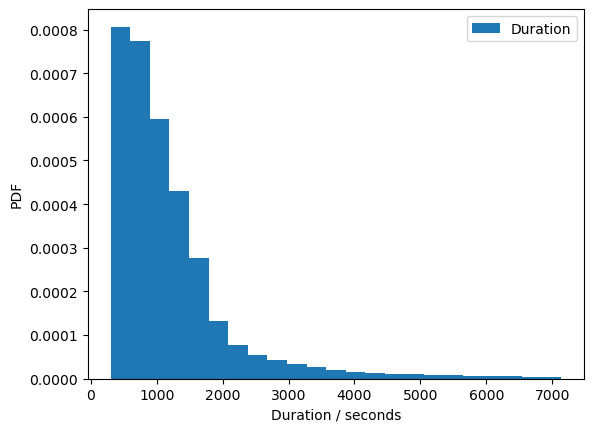

In [24]:
# finally we only want June (not May nor July which were included in the input files)

# conversion to expected timestamp format so can filter, and alias so easily refer to 'start'
temp_df = juneA_df.select(to_timestamp(col("Start Date"), format="dd/MM/yyyy HH:mm").alias("start"), "Duration")

# example how to filter for dates later than May, outputting example 5 dates for checking
# NB at this point temp_df still contains May & June
print("quick check we do not see any MAY dates")
temp_df.filter(temp_df.start > "2014-06-01 00:00:00").show(5)

# we can do similarly re juneB_df
temp2_df = juneB_df.select(to_timestamp(col('Start Date'), format="dd/MM/yyyy HH:mm").alias("start"), "Duration")

# do a UNION of only June data from the two datasets keeping only the Duration column
# i.e. we do a filter on each temp DF re 'start' then select only 'Duration' col and form the union of those subsets
june_df =  temp_df.filter(temp_df.start > "2014-06-01 00:00:00")[["Duration"]].union(temp2_df.filter(temp2_df.start < "2014-07-01 00:00:00")[["Duration"]])

# plot the June-only data for rides at least 5 mins but less than 2 hours (then compare to January, say)
print("plot PDF of cleansed data for June only, rides>=5m and <2hr")
june_df.filter("Duration >= 300").filter("Duration < 7200").toPandas().plot(kind="hist", bins=23, density=True)
plt.xlabel("Duration / seconds")
plt.ylabel("PDF")
#plt.ylim(minY, maxY)
plt.show()


In [ ]:
# TO DO: plot various months' PDF and gain empirical knowledge of how length of rides varies over the year 2014